# Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 5)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [16, 5]
pal = plt.get_cmap('Paired').colors

from tqdm import tqdm, tqdm_notebook
import quandl

In [3]:
from utils import *

In [4]:
# api_key = open(file='quandl_api').read().replace('\n', '')
# quandl.ApiConfig.api_key = api_key

# tickers, prices = get_quandl_sharadar(free=True)
# prices = prices.assign(Set='free')

tickers, prices = get_sharadar_train()
prices = prices.query('Set == "train"')

In [5]:
prices

Open    High    Low  Close      Volume  Dividends  \
Ticker Date                                                             
A      1999-11-18  45.50  50.000  40.00  44.00  44739900.0        0.0   
       1999-11-19  42.94  43.000  39.81  40.38  10897100.0        0.0   
...                  ...     ...    ...    ...         ...        ...   
ZYNE   2017-08-17   6.36   6.639   6.20   6.32    651837.0        0.0   
       2017-08-18   6.26   6.450   6.17   6.25    423696.0        0.0   

                   Closeunadj Lastupdated    Set  
Ticker Date                                       
A      1999-11-18       44.00  2018-02-11  train  
       1999-11-19       40.38  2018-02-11  train  
...                       ...         ...    ...  
ZYNE   2017-08-17        6.32  2017-11-01  train  
       2017-08-18        6.25  2017-11-01  train  

[14052292 rows x 9 columns]

In [6]:
ticker_days = prices.groupby('Ticker')[['Set']].count().rename(columns={'Set': 'n_days'}).reset_index()

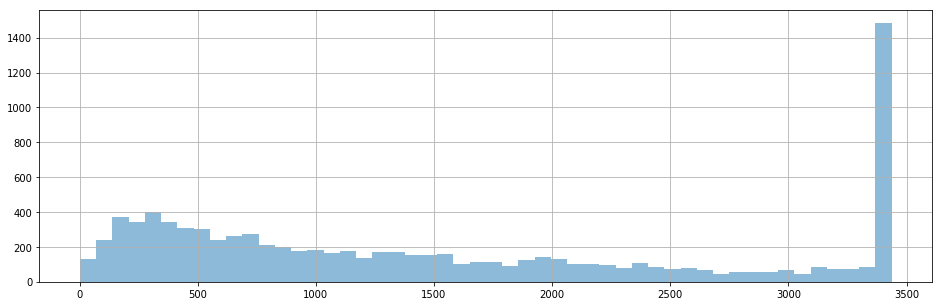

In [7]:
ticker_days.n_days.hist(bins=50, alpha=0.5)

# Finding the trend in a single price

See An introduction to smoothing time series in python, [part 1](http://www.nehalemlabs.net/prototype/blog/2013/04/05/an-introduction-to-smoothing-time-series-in-python-part-i-filtering-theory/) and [part 2](http://www.nehalemlabs.net/prototype/blog/2013/04/09/an-introduction-to-smoothing-time-series-in-python-part-ii-wiener-filter-and-smoothing-splines/).

Series to check:

* AKTC

1575 days.


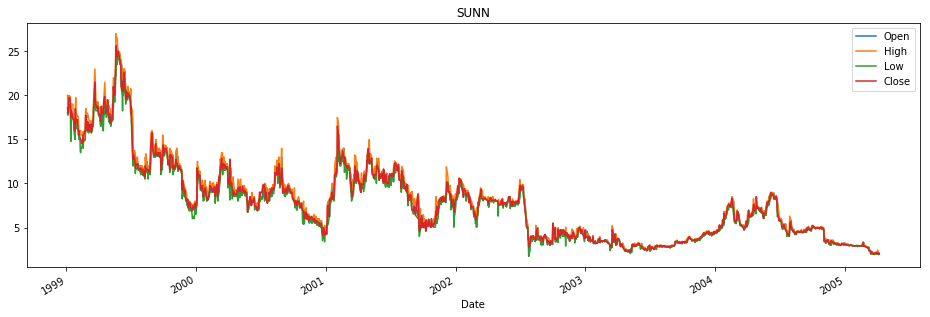

In [8]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(len(price), 'days.')
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title(ticker);

## Filters

In [9]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import scipy.optimize as op

### Linear 

In [10]:
N = 61
f_sma = np.ones(N) / N

### Gaussian

In [11]:
N_ga = 1500
f_ga = gaussian(N_ga, std=30.)
f_ga = f_ga / f_ga.sum()

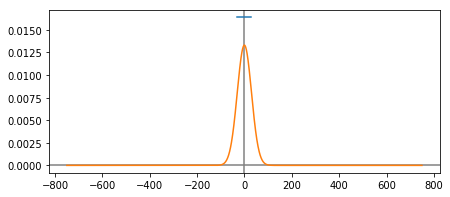

In [12]:
plt.figure(figsize=(7, 3))
plt.axhline(c='grey')
plt.axvline(c='grey')
plt.plot(np.arange(-N/2, N/2), f_sma, label='f_sma')
plt.plot(np.arange(-N_ga/2, N_ga/2), f_ga, label='f_ga')
plt.show()

### Geometric

In [13]:
f_geo = lambda s: np.exp(filters.convolve1d(np.log(price.Close), f_ga))

### Wiener 

In [14]:
sigma = np.std(price.Close)
f_wi = lambda x: wiener(x, mysize=N, noise=sigma)

### Spline

In [15]:
f_sp = lambda x: UnivariateSpline(np.arange(len(x)), x)(np.arange(len(x)))

### Results

<Figure size 1152x432 with 0 Axes>

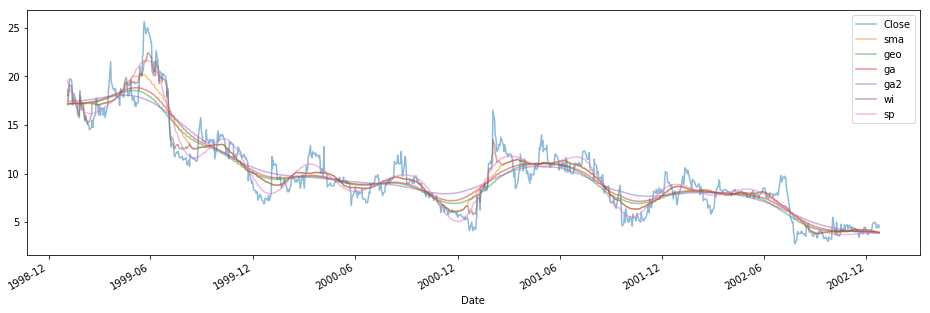

In [16]:
plt.figure(figsize=(16, 6))
results = price[['Close']].assign(
    sma=filters.convolve1d(price.Close, f_sma),
    geo=f_geo(price.Close),
    ga=filters.convolve1d(price.Close, f_ga),
    ga2=filters.convolve1d(filters.convolve1d(price.Close, f_ga), f_ga),
    wi=f_wi(price.Close),
    sp=f_sp(price.Close),
)
results[:1000].plot(alpha=0.5);

<Figure size 1152x432 with 0 Axes>

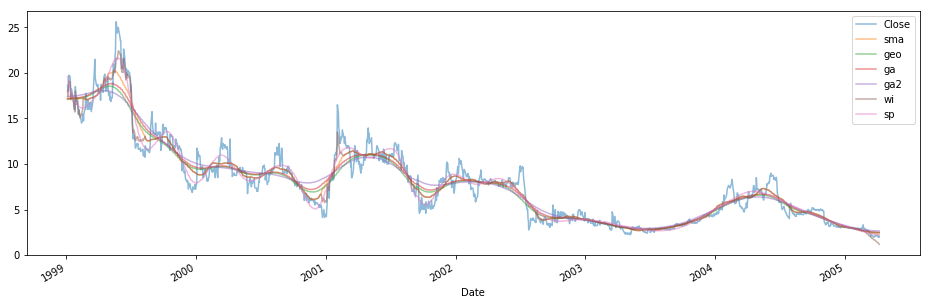

In [17]:
plt.figure(figsize=(16, 6));
results.plot(alpha = 0.5);

In [18]:
def smooth_price(df, N=151, std=20.):
    f_ga = gaussian(N_ga, std=std)
    f_ga = f_ga / f_ga.sum()
    df = df.assign(Smoothed=filters.convolve1d(df.Close, f_ga))
    
    return df

## Trends 

### Peaks and Valleys

In [19]:
from scipy.signal import find_peaks, find_peaks_cwt
from sklearn.metrics import confusion_matrix

In [20]:
results = smooth_price(price)

In [21]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed
Date,,,,,,,,,,
1999-01-04,NaN,20.000,18.00,18.625,12425.0,0.0,18.625,2018-02-11,train,17.366907
1999-01-05,NaN,18.875,17.75,18.000,18975.0,0.0,18.000,2018-02-11,train,17.363733
...,...,...,...,...,...,...,...,...,...,...
2005-04-07,2.11,2.110,2.10,2.100,200.0,0.0,2.100,2017-11-01,train,2.330084
2005-04-08,1.99,2.000,1.96,2.000,500.0,0.0,2.000,2017-11-01,train,2.329571


In [22]:
results = results.assign(Trend=np.nan, Max_Drawdown=np.nan)
peaks, _ = find_peaks(results.Smoothed)
valleys, _ = find_peaks(-results.Smoothed)

In [23]:
n_changes = min(len(peaks), len(valleys))
assert len(set(np.sign(peaks[:n_changes] - valleys[:n_changes]))) == 1

In [24]:
# End
if valleys.max() > peaks.max():
    peaks = np.concatenate((peaks, np.ones(1, dtype=np.int32) * len(results) - 1))
else:
    valleys = np.concatenate((valleys, np.ones(1, dtype=np.int32) * len(results) - 1))

In [25]:
peaks

array([  94,  177,  305,  410,  547,  595,  757,  821,  973, 1353],
      dtype=int64)

In [26]:
results.loc[results.index[peaks], 'Trend'] = 1
results.loc[results.index[valleys], 'Trend'] = -1
results.Trend.fillna(method='bfill', inplace=True)

In [27]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed,Trend,Max_Drawdown
Date,,,,,,,,,,,,
1999-01-04,NaN,20.000,18.00,18.625,12425.0,0.0,18.625,2018-02-11,train,17.366907,-1.0,NaN
1999-01-05,NaN,18.875,17.75,18.000,18975.0,0.0,18.000,2018-02-11,train,17.363733,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-07,2.11,2.110,2.10,2.100,200.0,0.0,2.100,2017-11-01,train,2.330084,-1.0,NaN
2005-04-08,1.99,2.000,1.96,2.000,500.0,0.0,2.000,2017-11-01,train,2.329571,-1.0,NaN


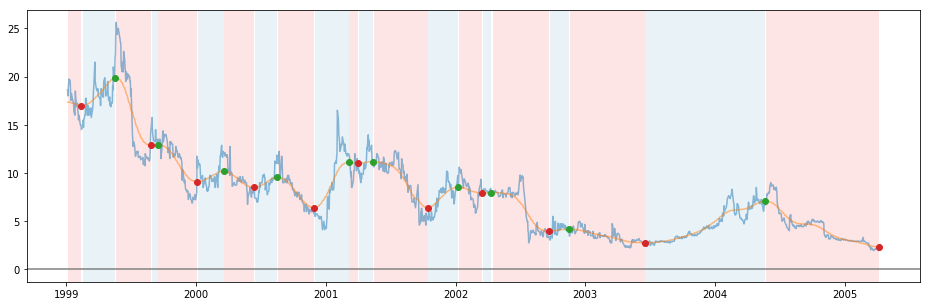

In [28]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

### Slopes

In [29]:
results = results.assign(Trend2=results.Smoothed.pct_change().apply(np.sign))
results.loc[results.index[0], 'Trend2'] = results.Trend2[1]

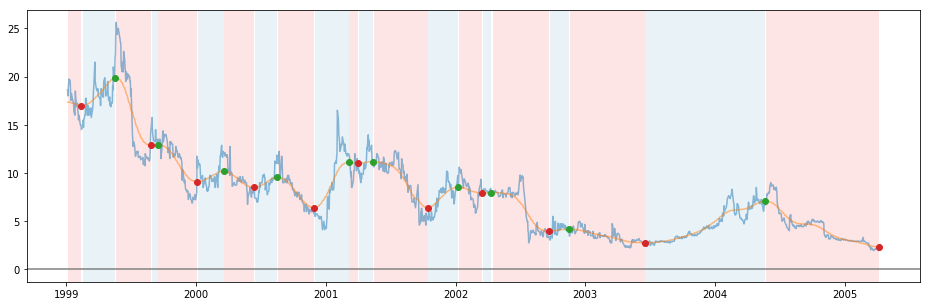

In [30]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend2 up')
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend2 down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

In [31]:
confusion_matrix(results.Trend.values, results.Trend2) / len(results)

array([[0.60507937, 0.        ],
       [0.        , 0.39492063]])

> Both methods are equivalent!!

## Max drawdown within trend

-> For trailing stop-loss orders...

In [32]:
breakpoints = np.concatenate((np.zeros(1, dtype=np.int32), peaks + 1, valleys + 1))
breakpoints.sort()
print('Breakpoints:', breakpoints)

Breakpoints: [   0   29   95  165  178  255  306  365  411  483  548  567  596  699
  758  803  822  934  974 1120 1354 1575]


In [33]:
b = 3
trend_start = breakpoints[b - 1]
trend_end = breakpoints[b]
res_b = results[trend_start:trend_end]
res_b

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed,Trend,Max_Drawdown,Trend2
Date,,,,,,,,,,,,,
1999-05-20,22.25,27.00,22.25,24.875,77100.0,0.0,24.875,2018-02-11,train,19.890560,-1.0,NaN,-1.0
1999-05-21,25.00,26.50,25.00,25.625,25425.0,0.0,25.625,2018-02-11,train,19.883156,-1.0,NaN,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999-08-26,12.50,14.50,12.25,14.000,27000.0,0.0,14.000,2018-02-11,train,12.872721,-1.0,NaN,-1.0
1999-08-27,14.25,15.75,13.75,14.500,38375.0,0.0,14.500,2018-02-11,train,12.872713,-1.0,NaN,-1.0


In [34]:
for b in range(1, len(breakpoints)):

    trend_start = breakpoints[b - 1]
    trend_end = breakpoints[b]
    res_b = results[trend_start:trend_end]
    trend_b = res_b.Trend[0]

    # Adjust for position (long, short)
    close_b = res_b.Close[0] * res_b.Close.pct_change()[1:].mul(trend_b).add(1).cumprod()  
    close_b[res_b.index[0]] = res_b.Close[0]
    close_b = close_b.sort_index()

    peak = close_b[0]
    low = peak
    drawdown = 0
    max_drawdown = 0

    for i in range(1, len(close_b)):
        # Max drawdown
        if close_b[i] > peak:
            peak = close_b[i]
            low = peak
        if close_b[i] < low:
            low = close_b[i]
            drawdown = low / peak - 1
        max_drawdown = min(drawdown, max_drawdown)
    
    results.loc[res_b.index, 'Max_Drawdown'] = -max_drawdown
    

In [35]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed,Trend,Max_Drawdown,Trend2
Date,,,,,,,,,,,,,
1999-01-04,NaN,20.000,18.00,18.625,12425.0,0.0,18.625,2018-02-11,train,17.366907,-1.0,0.156250,-1.0
1999-01-05,NaN,18.875,17.75,18.000,18975.0,0.0,18.000,2018-02-11,train,17.363733,-1.0,0.156250,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-07,2.11,2.110,2.10,2.100,200.0,0.0,2.100,2017-11-01,train,2.330084,-1.0,0.394513,-1.0
2005-04-08,1.99,2.000,1.96,2.000,500.0,0.0,2.000,2017-11-01,train,2.329571,-1.0,0.394513,-1.0


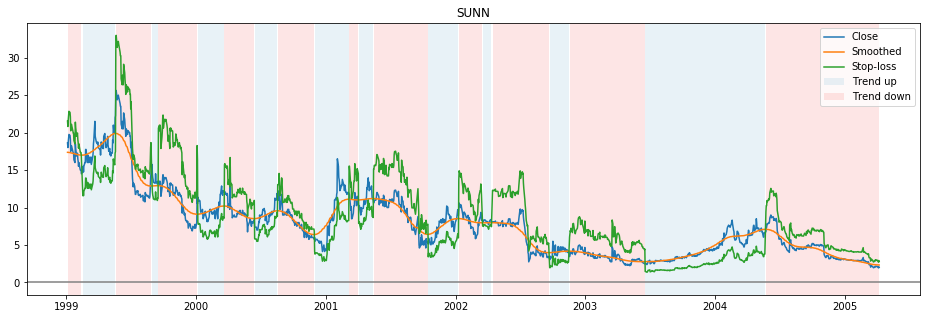

In [36]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results.Close, label='Close')
plt.plot(results.Smoothed, label='Smoothed')
plt.plot(results.Close * (1 - results.Max_Drawdown * results.Trend), label='Stop-loss')
plt.axhline(0, c='grey')
plt.legend()
plt.title(ticker)
plt.show()

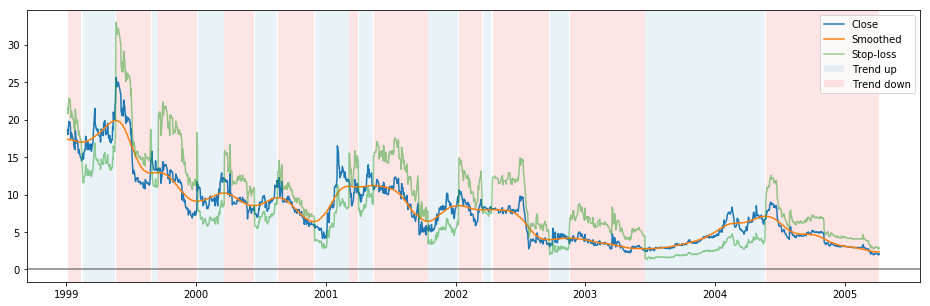

In [37]:
res2 = find_trends(price)
plot_trends(res2)

# Sample...

## A single asset 

In [213]:
from utils import *

In [188]:
ticker = np.random.choice(tickers)
# ticker = 'TFCO'
price = prices.loc[ticker]
print(len(price), 'days.')

2394 days.


first: 18.0 , last: 18.153786093068895
first: 14.187999999999999 , last: 18.0
first: 17.063 , last: 15.607498095624585
first: 10.812999999999999 , last: 21.799999999999955
first: 22.49 , last: 23.80622859069176
first: 11.19 , last: 9.810000000000002
first: 10.269 , last: 9.231342984547178
first: 9.73 , last: 22.449999999999985
first: 22.44 , last: 34.665253154244255
first: 13.03 , last: 22.04999999999999
first: 22.64 , last: 29.44297962146228
first: 15.1 , last: 15.359999999999992
first: 15.15 , last: 27.484007495483297
first: 6.74 , last: 9.51999999999999
first: 9.74 , last: 11.00646588709769
first: 7.73 , last: 8.449999999999992


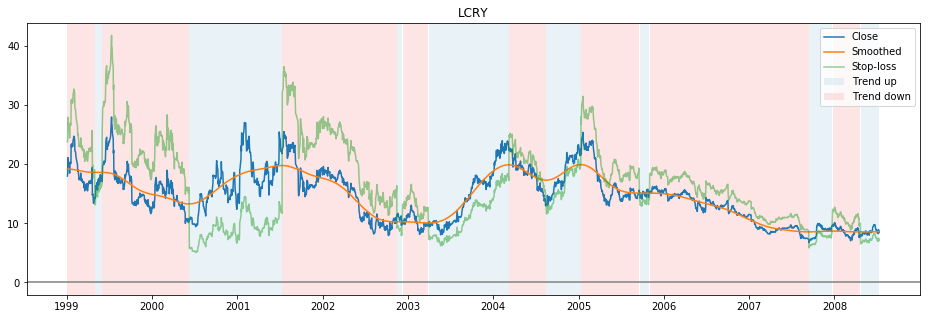

In [214]:
trends = find_trends(price, sd=50.)
plot_trends(trends, ticker)

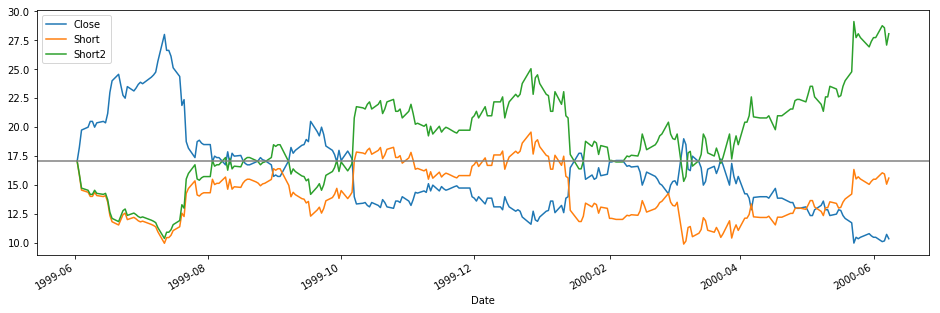

In [231]:
price3 = price.loc[trends.query('n_Trend == 3').index]
price3.assign(Short = price3.Close[0] * price3.Close.pct_change().fillna(value=0).mul(trend_b).add(1).cumprod(),
              Short2 = price3.Close[0] * price3.Close.pct_change().fillna(value=0).add(1).pow(trend_b).cumprod())[['Close', 'Short', 'Short2']].plot()
plt.axhline(price3.Close[0], c='grey')

In [215]:
pd.set_option('display.max_rows', 20)
trends.reset_index().groupby('n_Trend').first().head(20)

,Date,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed,Trend,Max_Drawdown,Ratio,ICAGR
n_Trend,,,,,,,,,,,,,,,
1.0,1999-01-04,15.875,18.125,16.500,18.000,24200.0,0.0,18.000,2018-02-11,train,19.202130,-1.0,0.322506,1.008544,0.026714
2.0,1999-05-03,14.750,14.750,14.000,14.188,21300.0,0.0,14.188,2018-02-11,train,18.618969,1.0,0.074074,1.268678,2.989051
3.0,1999-06-02,17.750,17.875,16.750,17.063,11200.0,0.0,17.063,2018-02-11,train,18.635005,-1.0,0.493527,0.914698,-0.087303
4.0,2000-06-09,10.750,10.813,10.313,10.813,24700.0,0.0,10.813,2017-11-01,train,13.284991,1.0,0.463105,2.016092,0.643320
5.0,2001-07-12,21.860,22.500,21.860,22.490,50400.0,0.0,22.490,2017-11-01,train,19.790285,-1.0,0.429859,1.058525,0.042280
6.0,2002-11-15,11.629,11.629,10.700,11.190,18100.0,0.0,11.190,2017-11-01,train,10.265267,1.0,0.177692,0.876676,-2.282950
7.0,2002-12-09,9.820,10.460,9.520,10.269,17286.0,0.0,10.269,2017-11-01,train,10.268476,-1.0,0.269501,0.898952,-0.355980
8.0,2003-03-31,9.750,10.040,9.730,9.730,5800.0,0.0,9.730,2017-11-01,train,10.054490,1.0,0.231649,2.307297,0.887874
9.0,2004-03-09,22.500,22.750,22.060,22.440,9525.0,0.0,22.440,2017-11-01,train,19.908141,-1.0,0.110629,1.544797,1.008979


In [176]:
DataFrame(trends.groupby('n_Trend').Trend.count().describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
Trend,24.0,18.958333,14.912729,4.0,9.0,15.5,20.5,70.0


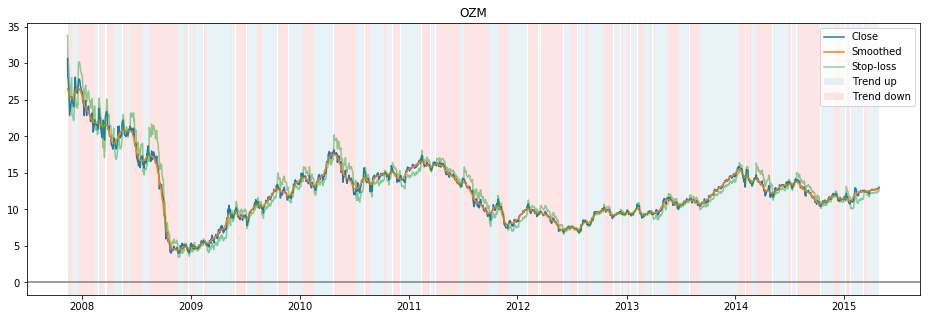

In [42]:
trends2 = find_trends(price, sd=5.)
plot_trends(trends2, ticker)

In [43]:
DataFrame(trends2.groupby('n_Trend').Trend.count().describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
Trend,84.0,22.321429,16.998342,2.0,10.0,16.5,29.5,91.0


In [44]:
sds = np.arange(5, 150, step=30)
sum_trends = pd.concat([summarise_trends(price, s) for s in sds], axis=0)

In [45]:
sum_trends

,count,mean,std,min,25%,50%,75%,max,sd,n_days
0,84.0,22.321429,16.998342,2.0,10.00,16.5,29.50,91.0,5,1875
0,10.0,187.500000,119.518711,24.0,101.50,173.5,271.75,396.0,35,1875
0,8.0,234.375000,141.139179,37.0,113.25,259.5,336.50,422.0,65,1875
0,5.0,375.000000,66.456753,276.0,338.00,411.0,415.00,435.0,95,1875
0,5.0,375.000000,80.012499,252.0,360.00,370.0,445.00,448.0,125,1875


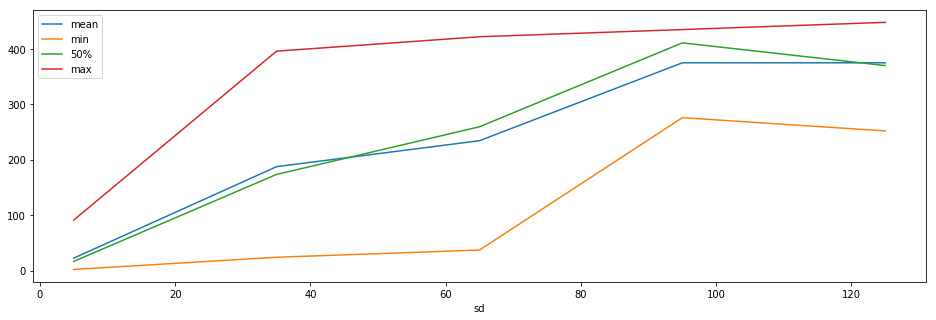

In [46]:
sum_trends.set_index('sd')[['mean', 'min', '50%', 'max']].plot();

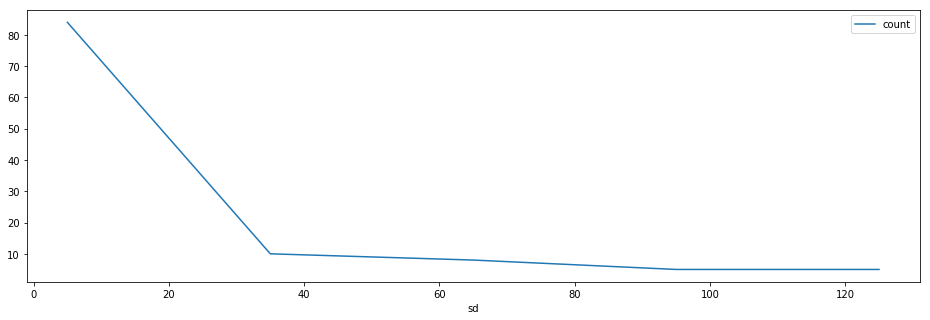

In [47]:
sum_trends.set_index('sd')[['count']].plot();

## Multiple assets

### Single thread

In [95]:
from utils import *
# summarise_trends(prices.loc['A'], sd=100)
# results = pickle.load(open('output/Finding the trends - sd values for filtering.pickle', 'rb'))

In [96]:
n_tickers = 100
sds = np.arange(10, 510, step=10)

results = []
grouped = prices.loc[np.random.choice(tickers, size=n_tickers)].groupby('Ticker')
# grouped = prices.loc[list(set(results_df.Ticker.values))].groupby('Ticker')

for name, group in tqdm_notebook(grouped, desc='Ticker:'):
    
    res_g = []
    for s in tqdm_notebook(sds, desc='sd:', leave=False):
        try:
            res_g.append(summarise_trends(group, s))
        except:
            pass
    try:
        results.append(pd.concat(res_g, axis=0).assign(Ticker=name))
    except:
        pass

In [97]:
pickle.dump(results, open('output/Finding the trends - std values for filtering.pickle', 'wb'))

### Results

In [112]:
results_df = pd.concat(results, axis=0, sort=True)
results_df = results_df.assign(trend_freq=364.25*results_df['count'].astype(np.float64)/results_df.n_days.astype(np.float64))
results_df = results_df.query('n_days > 3 * sd')

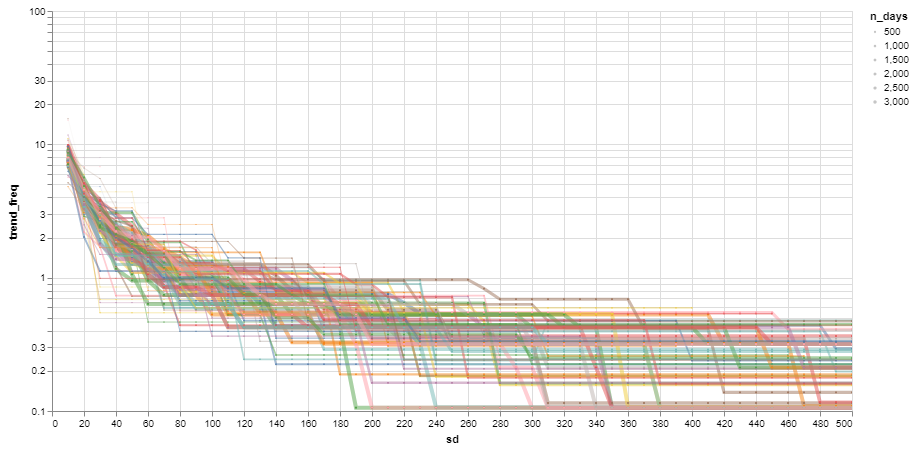

In [115]:
import altair as alt
alt.renderers.enable('notebook')
alt.Chart(results_df.reset_index()).mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y=alt.Y('trend_freq', scale=alt.Scale(type='log')), #y='trend_freq',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=800,
    height=400
).interactive()

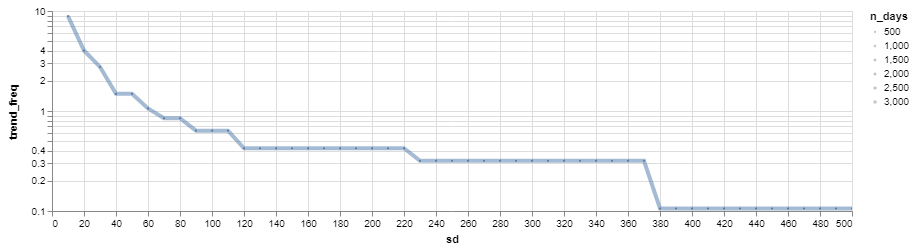

In [142]:
import altair as alt
alt.renderers.enable('notebook')
alt.Chart(results_df.reset_index().query('Ticker == "GBCI"')).mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y=alt.Y('trend_freq', scale=alt.Scale(type='log')), #y='trend_freq',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=800,
    height=200
).interactive()

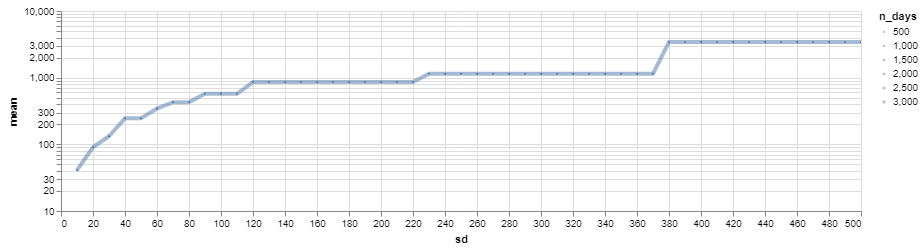

In [148]:
import altair as alt
alt.renderers.enable('notebook')
alt.Chart(results_df.reset_index().query('Ticker == "GBCI"')).mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y=alt.Y('mean', scale=alt.Scale(type='log')), #y='trend_freq',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=800,
    height=200
).interactive()

In [141]:
ticker = np.random.choice(results_df.Ticker)  #ticker = 'APWC'
price = prices.loc[ticker]
print(ticker, len(price), 'days.')

GBCI 3437 days.


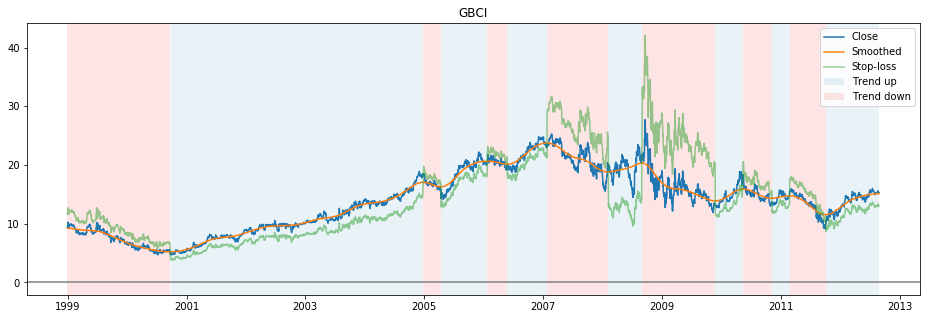

In [146]:
trends = find_trends(price, sd=40)
plot_trends(trends, ticker)

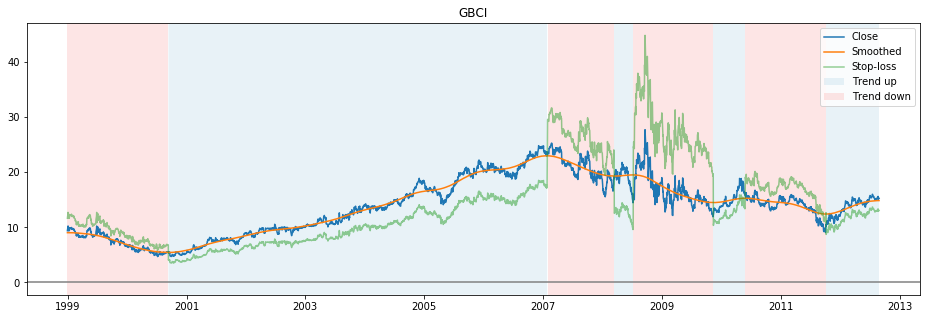

In [147]:
trends = find_trends(price, sd=70)
plot_trends(trends, ticker)

# TO DO:

* Asset selection.
  * By small or negative change correlations.
  * Highest signal to noise ratios (see Kaufman, 2005, pp. 870).
* Exit by volume (~extreme reduction, bankrupt, ...).
* Feature engineering.
  * c.f. fast.ai's `add_datepart` function.